# Resuming Training

This notebook illustrates how to resume training from a checkpoint. In this example, the checkpoint has been saved to Google Drive.

## Notebook setup and imports

In [ ]:
!pip install "pytorch_lightning==1.1.5" tokenizers wandb --quiet

     |████████████████████████████████| 686kB 9.1MB/s 
     |████████████████████████████████| 3.2MB 19.6MB/s 
     |████████████████████████████████| 1.9MB 53.4MB/s 
     |████████████████████████████████| 829kB 59.1MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 645kB 53.3MB/s 
     |████████████████████████████████| 163kB 55.3MB/s 
     |████████████████████████████████| 102kB 12.5MB/s 
     |████████████████████████████████| 133kB 59.7MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 1.3MB 53.3MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 296kB 53.3MB/s 
     |████████████████████████████████| 143kB 51.8MB/s 


In [ ]:
%load_ext autoreload
%autoreload 2

# Connecting to Google Drive will allow us to load the Kaggle dataset and
# checkpoint models during training

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys

import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

In [ ]:
# Log metrics to https://wandb.ai/
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# For Reproducibility
pl.seed_everything(42)

Global seed set to 42


42

In [ ]:
# Setup Google Drive paths
GOOGLE_DRIVE_PATH_FOR_PROJECT = 'captioning'  # Location of project files in Google Drive
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_FOR_PROJECT)
print(os.listdir(GOOGLE_DRIVE_PATH))
sys.path.append(GOOGLE_DRIVE_PATH)

['.ipynb_checkpoints', '__pycache__', 'flickr30k.zip', '.gitignore', 'README.md', 'setup.cfg', 'requirements.txt', 'LICENSE', 'tests', 'project', 'setup.py', 'checkpoints']


In [ ]:
# Import project modules from Google Drive
from project.captioners import CaptioningRNN
from project.datasets import load_flickr_csv, load_coco_captions_json, CombinedDataModule, sample_minibatch
from project.utils import sample_predictions

In [ ]:
# Make sure we have a GPU
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Select Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU')

Good to go!


## Download training data

In [ ]:
# Copy Flickr dataset from Google Drive and unzip; this will take a few minutes
if not os.path.exists('flickr30k_images'):
    GOOGLE_DRIVE_FLICKR_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_FOR_PROJECT, 'flickr30k.zip')
    !cp $GOOGLE_DRIVE_FLICKR_PATH .
    !unzip 'flickr30k.zip' > /dev/null
!ls flickr30k_images

flickr30k_images  results.csv


In [ ]:
# Preview Flickr dataset
FLICKR30K_IMG_DIR = 'flickr30k_images/flickr30k_images'
FLICKR30K_CSV_PATH = 'flickr30k_images/results.csv'

captions_df = load_flickr_csv(FLICKR30K_CSV_PATH, FLICKR30K_IMG_DIR)
captions_df.head()

,path,0,1,2,3,4
0,flickr30k_images/flickr30k_images/1000092795.jpg,two young guys with shaggy hair look at their ...,two young white males are outside near many ...,two men in green shirts are standing in a yard,a man in a blue shirt standing in a garden,two friends enjoy time spent together
1,flickr30k_images/flickr30k_images/10002456.jpg,several men in hard hats are operating a giant...,workers look down from up above on a piece of ...,two men working on a machine wearing hard hats,four men on top of a tall structure,three men on a large rig
2,flickr30k_images/flickr30k_images/1000268201.jpg,a child in a pink dress is climbing up a set o...,a little girl in a pink dress going into a woo...,a little girl climbing the stairs to her playh...,a little girl climbing into a wooden playhouse,a girl going into a wooden building
3,flickr30k_images/flickr30k_images/1000344755.jpg,someone in a blue shirt and hat is standing on...,a man in a blue shirt is standing on a ladder ...,a man on a ladder cleans the window of a tall ...,man in blue shirt and jeans on ladder cleaning...,a man on a ladder cleans a window
4,flickr30k_images/flickr30k_images/1000366164.jpg,two men one in a gray shirt one in a black...,two guy cooking and joking around with the cam...,two men in a kitchen cooking food on a stove,two men are at the stove preparing food,two men are cooking a meal


In [ ]:
# Download the COCO captions dataset and unzip
DOWNLOAD_COCO = True
if DOWNLOAD_COCO:
    if not os.path.exists('coco2014_train'):
        !curl -L -C - http://images.cocodataset.org/zips/train2014.zip -o train2014.zip
        !unzip 'train2014.zip' -d coco2014_train > /dev/null
        !curl -L -C - http://images.cocodataset.org/annotations/annotations_trainval2014.zip -o annotations_trainval2014.zip
        !unzip 'annotations_trainval2014.zip' -d coco_labels > /dev/null
    !ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.5G  100 12.5G    0     0  44.7M      0  0:04:47  0:04:47 --:--:-- 46.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  33.0M      0  0:00:07  0:00:07 --:--:-- 46.2M
annotations_trainval2014.zip  coco_labels  flickr30k_images  sample_data
coco2014_train		      drive	   flickr30k.zip     train2014.zip


In [ ]:
# Preview COCO dataset
if DOWNLOAD_COCO:
    COCO_JSON_PATH = 'coco_labels/annotations/captions_train2014.json'
    COCO_IMG_DIR = 'coco2014_train/train2014'

    captions_df = load_coco_captions_json(COCO_JSON_PATH, COCO_IMG_DIR)
captions_df.head()

,path,0,1,2,3,4
0,coco2014_train/train2014/COCO_train2014_000000...,a restaurant has modern wooden tables and chairs,a long restaurant table with rattan rounded ba...,a long table with a plant on top of it surroun...,a long table with a flower arrangement in the ...,a table is adorned with wooden chairs with blu...
1,coco2014_train/train2014/COCO_train2014_000000...,a man preparing desserts in a kitchen covered ...,a chef is preparing and decorating many small ...,a baker prepares various types of baked goods,a close up of a person grabbing a pastry in a ...,close up of a hand touching various pastries
2,coco2014_train/train2014/COCO_train2014_000000...,a big red telephone booth that a man is standi...,a person standing inside of a phone booth,this is an image of a man in a phone booth,a man is standing in a red phone booth,a man using a phone in a phone booth
3,coco2014_train/train2014/COCO_train2014_000000...,the kitchen is full of spices on the rack,a kitchen with counter oven and other accesso...,a small kitchen that utilizes all of its space,this small kitchen has pots pans and spices o...,a very small kitchen with a stove and a shelf ...
4,coco2014_train/train2014/COCO_train2014_000000...,a child and woman are cooking in the kitchen,a woman glances at a young girls cooking on th...,a young girl and a woman preparing food in a k...,a young person and an older person in a kitchen,two women cooking on stove in a kitchen together


## Overfitting sanity check

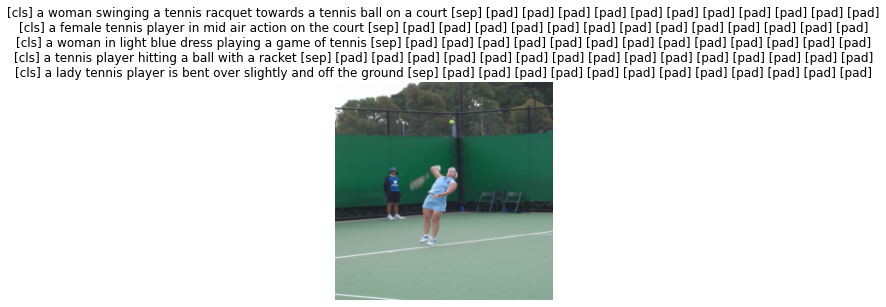

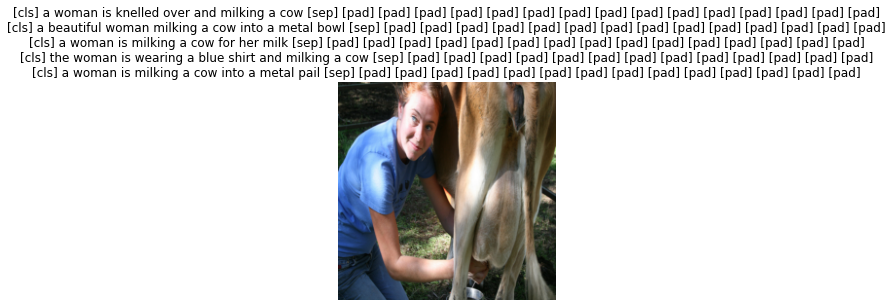

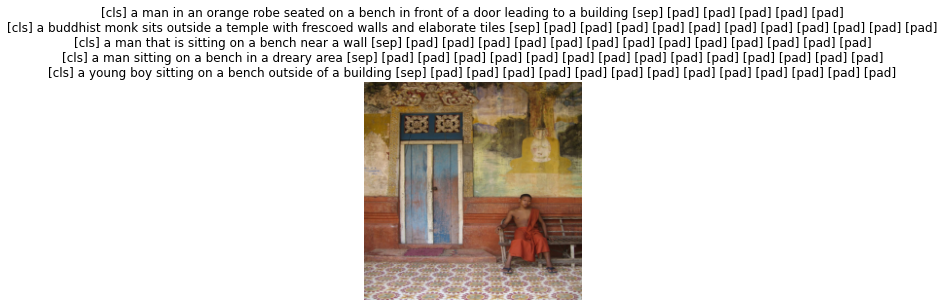

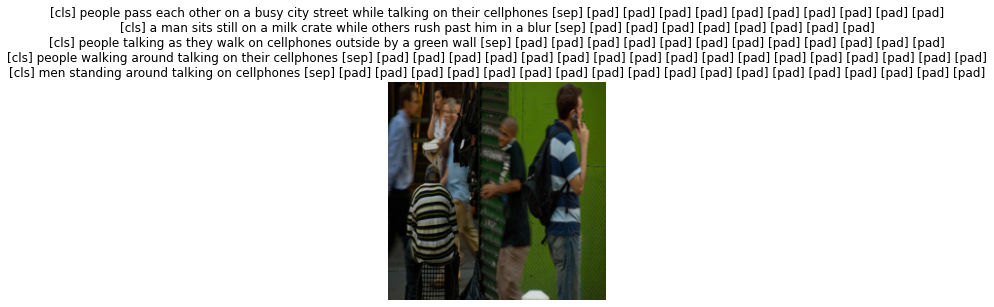

In [ ]:
# # Sanity overfitting check: First, make a tiny dataset
# tiny_dataset = CombinedDataModule(
#     flickr_csv=FLICKR30K_CSV_PATH,
#     flickr_dir=FLICKR30K_IMG_DIR,
#     coco_json=COCO_JSON_PATH,
#     coco_dir=COCO_IMG_DIR,
#     num_workers=2,
#     batch_size=4,
#     dev_set=12,
#     val_size=4,
#     test_size=4,
#     transform='normalize',
#     target_transform='tokenize',
# )
# tiny_dataset.setup()

# # Check out the images and captions
# minibatch = next(iter(tiny_dataset.train_dataloader()))
# sample_minibatch(minibatch, tiny_dataset.tokenizer, remove_special_tokens=False)

In [ ]:
# overfitting_config = CaptioningRNN.default_config()
# overfitting_config["rnn_dropout"] = False

# overfitting_model = CaptioningRNN(tiny_dataset, overfitting_config)
# overfitting_model.hparams

"batch_size":              64
"encoder_init":            xavier
"fc_init":                 xavier
"hidden_size":             576
"image_encoder":           resnext50
"inference_beam_alpha":    0.9
"inference_beam_width":    10
"label_smoothing_epsilon": 0.05
"learning_rate":           0.0003
"max_length":              25
"momentum":                0.9
"num_rnn_layers":          3
"num_rnns":                1
"optimizer":               adam
"rnn_bidirectional":       False
"rnn_dropout":             False
"rnn_init":                None
"rnn_nonlinearity":        None
"rnn_type":                attention
"scheduler":               plateau
"wd_embedder_init":        xavier
"wordvec_dim":             768

In [ ]:
# overfitting_trainer = pl.Trainer(
#     gpus=1,
#     max_epochs=250,
#     num_sanity_val_steps=2,
#     progress_bar_refresh_rate=50,
#     check_val_every_n_epoch=250,
#     )

# overfitting_trainer.fit(overfitting_model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                  | Params
----------------------------------------------------------
0 | val_bleu        | CorpusBleu            | 0     
1 | test_bleu       | CorpusBleu            | 0     
2 | image_extractor | ImageFeatureExtractor | 24.2 M
3 | word_embedder   | WordEmbedder          | 391 K 
4 | decoder         | ParallelAttentionLSTM | 4.8 M 
5 | fc_scorer       | ParallelFCScorer      | 294 K 
----------------------------------------------------------
6.6 M     Trainable params
23.0 M    Non-trainable params
29.6 M    Total params


1

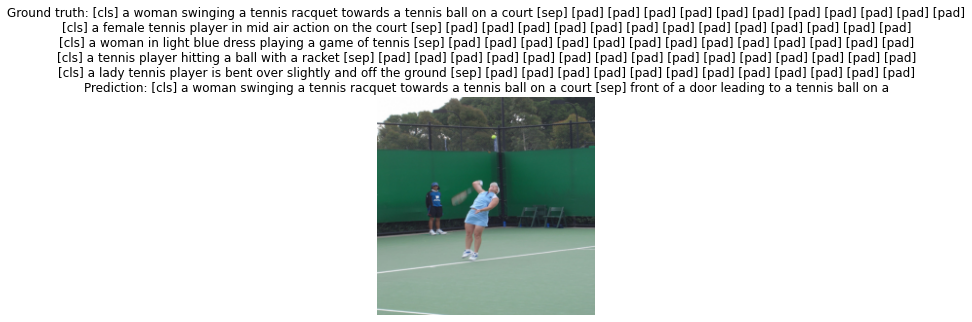

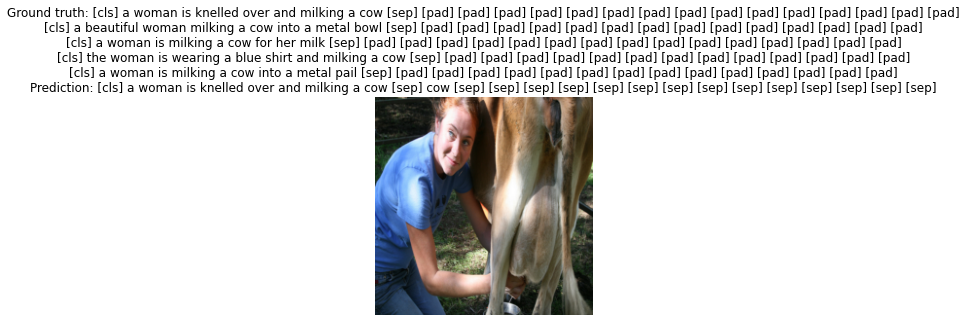

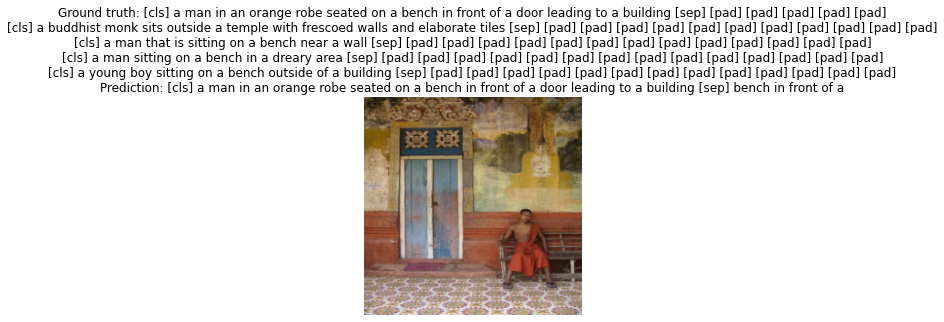

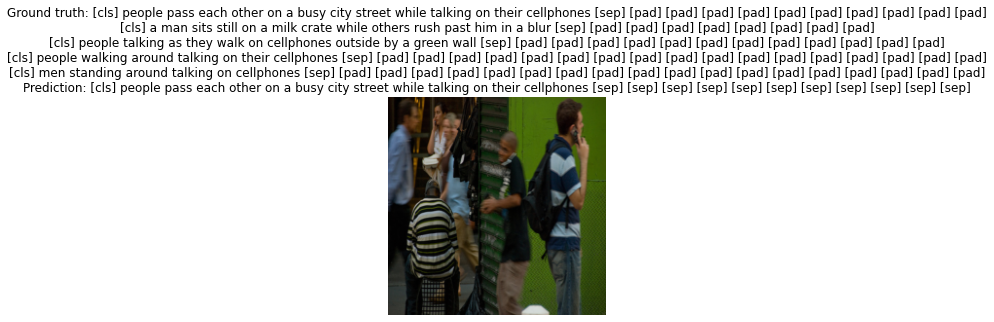

In [ ]:
# overfitting_model.inference_beam_width = 1
# overfitting_model.inference_beam_alpha = 0.
# sample_predictions(minibatch, overfitting_model)

## Set up dataset

In [ ]:
# Download vocab file from previous training session.
!curl -L -C - "https://raw.githubusercontent.com/reppertj/image-captioning/master/tokenizer/vocab.txt" -o "vocab.txt"

** Resuming transfer from byte position 11703
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 20518  100 20518    0     0  80462      0 --:--:-- --:--:-- --:--:-- 80148


In [ ]:
# Reinstantiate the dataset, passing in the vocab file
fdm = CombinedDataModule(
    flickr_csv=FLICKR30K_CSV_PATH,
    flickr_dir=FLICKR30K_IMG_DIR,
    coco_json=COCO_JSON_PATH,
    coco_dir=COCO_IMG_DIR,
    pretrained_vocab='vocab.txt',
    num_workers=2,
    batch_size=128,
)

In [ ]:
# Setup the dataset
fdm.setup()

## Restore from checkpoint and resume training

In [ ]:
# Restore from the checkpoint, with different hyperparameters if desired
checkpoint_path = os.path.join(GOOGLE_DRIVE_PATH, 'checkpoints', 'attn-lstm-5000-epoch=3-val_loss=3.73.ckpt')
model = CaptioningRNN.load_from_checkpoint(checkpoint_path, datamodule=fdm, batch_size=128)

In [ ]:
# Double check the model's hyperparameters
model.hparams

"batch_size":              128
"datamodule":              <project.datasets.CombinedDataModule object at 0x7f7649e522b0>
"encoder_init":            kaiming
"fc_init":                 kaiming
"hidden_size":             1024
"image_encoder":           resnext50
"inference_beam_alpha":    0.9
"inference_beam_width":    10
"label_smoothing_epsilon": 0.1
"learning_rate":           0.0003
"max_length":              25
"momentum":                0.9
"num_rnn_layers":          4
"num_rnns":                1
"optimizer":               adamw
"rnn_bidirectional":       False
"rnn_dropout":             0.1
"rnn_init":                None
"rnn_nonlinearity":        None
"rnn_type":                attention
"scheduler":               plateau
"wd_embedder_init":        xavier
"wordvec_dim":             512

In [ ]:
# Create a callback to save the best models during training
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename='attn-lstm-5000-resume01-{epoch}-{val_loss:.2f}',
    dirpath=os.path.join(GOOGLE_DRIVE_PATH, 'checkpoints'),
    monitor='val_loss',
    mode='min',
    save_top_k=10
    )

# Log to wandb (or use another logger if desired)
wandb_logger = WandbLogger(entity='collaborativeml', project='attention_lstm', log_model=True)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory drive/My Drive/captioning/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)


In [ ]:
# Resume training by passing the checkpoint path to the trainer as well
trainer = pl.Trainer(
    resume_from_checkpoint=checkpoint_path,
    gpus=1,
    max_epochs=1000,
    num_sanity_val_steps=1,
    progress_bar_refresh_rate=50,
    auto_scale_batch_size='binsearch',
    auto_lr_find=True,
    callbacks=[checkpoint_callback],
    logger=wandb_logger,
    benchmark=True,
    gradient_clip_val=0.5,
    )

trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: justinreppert (use `wandb login --relogin` to force relogin)



  | Name            | Type                  | Params
----------------------------------------------------------
0 | val_bleu        | CorpusBleu            | 0     
1 | test_bleu       | CorpusBleu            | 0     
2 | image_extractor | ImageFeatureExtractor | 25.1 M
3 | word_embedder   | WordEmbedder          | 2.6 M 
4 | decoder         | ParallelAttentionLSTM | 11.5 M
5 | fc_scorer       | ParallelFCScorer      | 5.1 M 
----------------------------------------------------------
21.3 M    Trainable params
23.0 M    Non-trainable params
44.3 M    Total params
Restored states from the checkpoint file at drive/My Drive/captioning/checkpoints/attn-lstm-5000-epoch=3-val_loss=3.73.ckpt
